In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer

In [2]:
all_df = pd.read_csv('TrainDataset2024.csv', index_col = False)
all_df.head()
len(all_df.index)

400

In [3]:
# Remove ID
all_df = all_df.drop('ID', axis=1)

# Remove rows with missing outcome
index = all_df[all_df["pCR (outcome)"] == 999].index
all_df.drop(index, inplace=True)

# Create y X, removing regression label
y = all_df["pCR (outcome)"]
X = all_df.drop(columns=["RelapseFreeSurvival (outcome)", "pCR (outcome)"])

# Replace missing values with median
imputer = SimpleImputer(missing_values=999, strategy="median")
imputer.set_output(transform="pandas")
X = imputer.fit_transform(X)

https://link.springer.com/article/10.1007/s10916-018-0940-7

Concludes good results come from replacing outliers with median and using RF for feature selection and classication

Permutation importance index (PIM) used to order features by importance
RF is then used to select the best combination of features for classification

In [4]:
columns = X.columns
medians = {}
# Need to save the training set medians so that test set can be mutated accordingly
for column in columns:
    medians[column] = X[column].median()

'''
def replace_outliers_with_median_std(df, columns=None, num_std=2):
    if columns is None:
        columns = df.columns
    for column in columns:
        mean = df[column].mean()  
        std = df[column].std()       
        lower_bound = mean - num_std * std  
        upper_bound = mean + num_std * std  
            
        median = medians[column]
        
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
'''

def replace_outliers_with_median(df):
    columns = df.columns 
    for column in columns:
        Q1 = df[column].quantile(0.25) 
        Q3 = df[column].quantile(0.75)  
        IQR = Q3 - Q1                  
        lower_bound = Q1 - 1.5 * IQR   
        upper_bound = Q3 + 1.5 * IQR   
        median = df[column].median()  
        
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)



replace_outliers_with_median(X)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

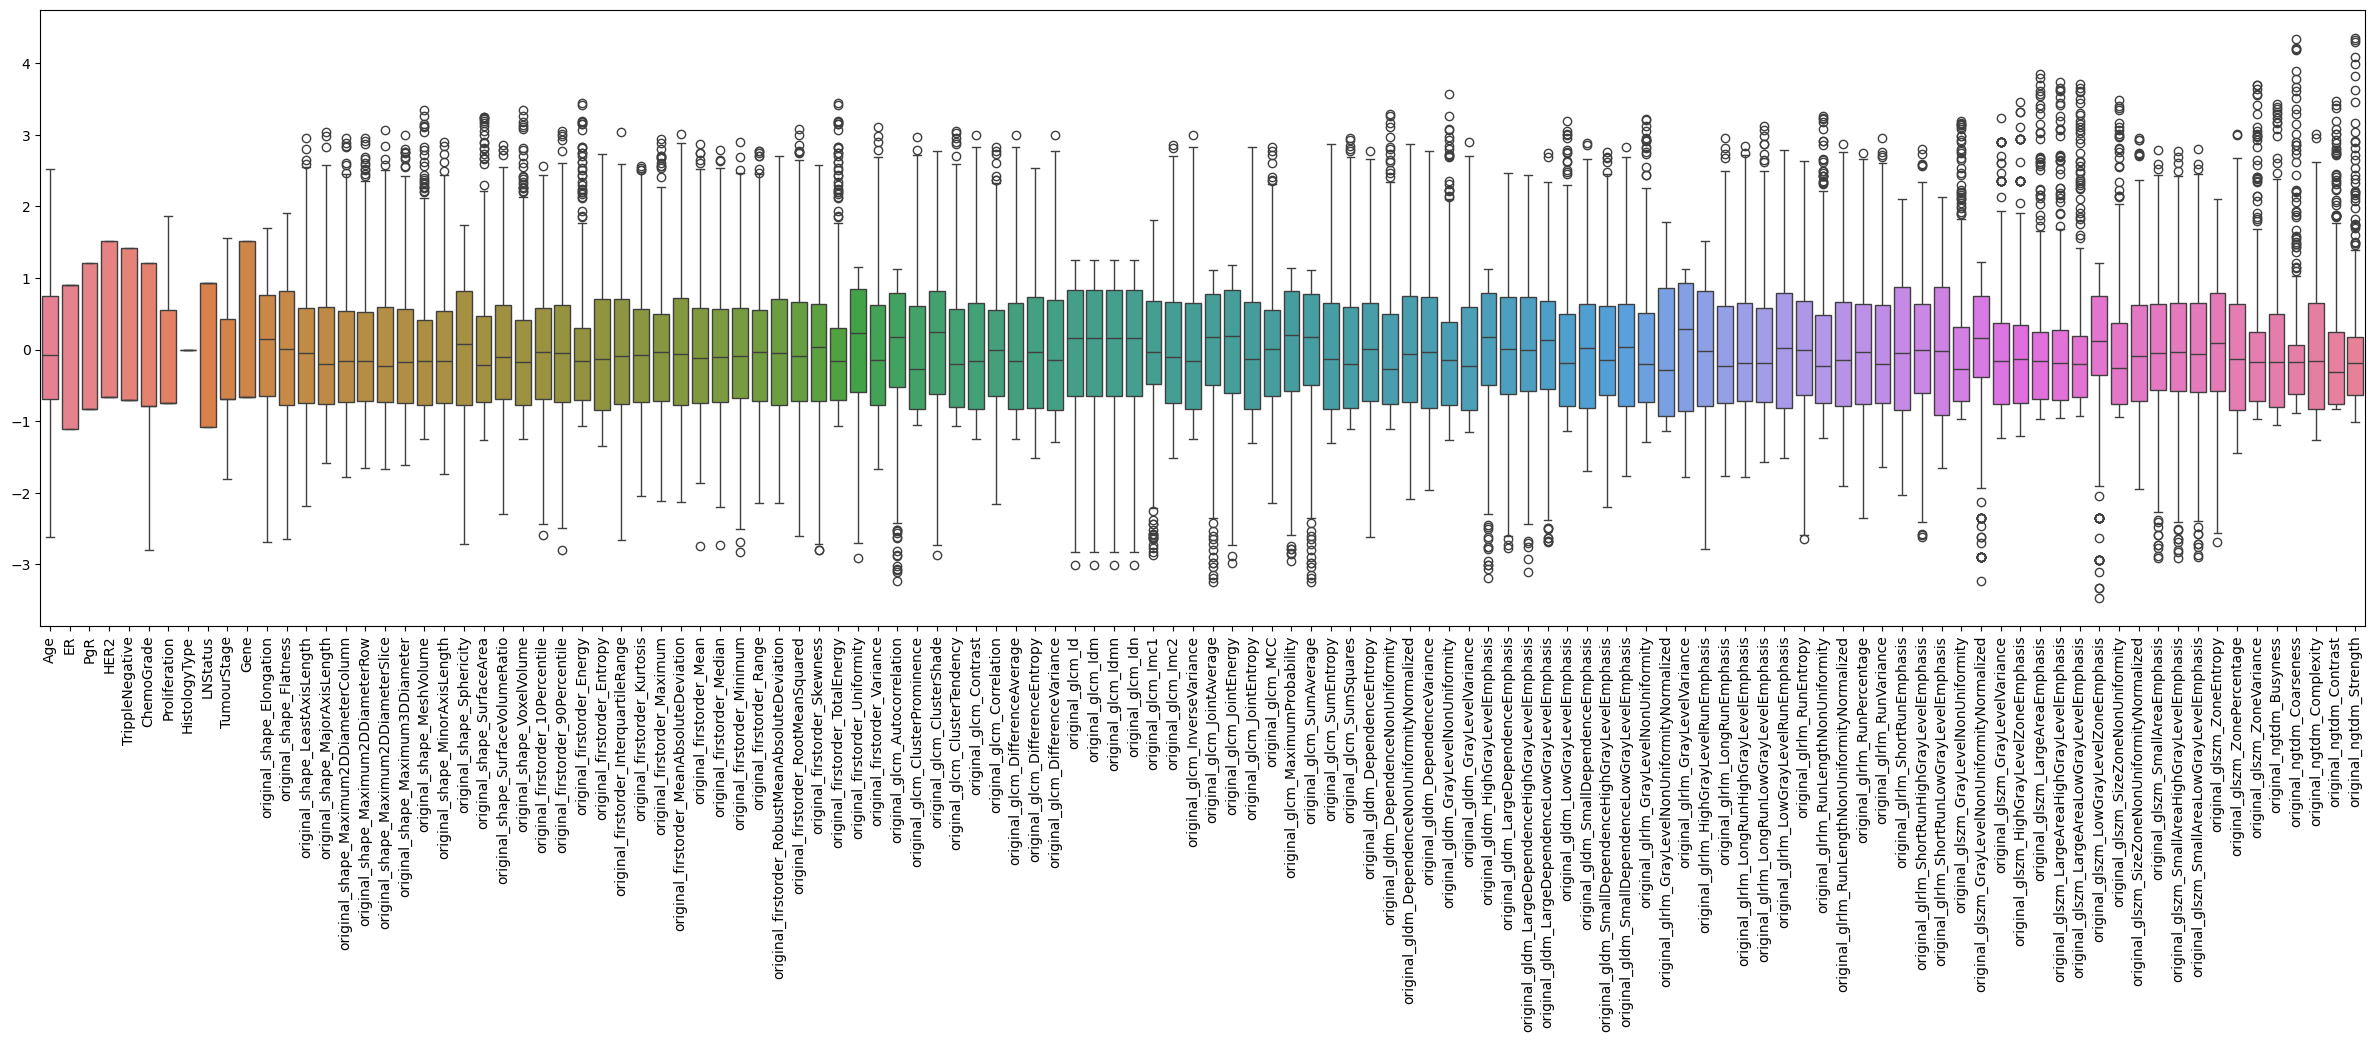

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.set_output(transform="pandas")
Xs = scaler.fit_transform(X)

fig,ax = plt.subplots(1,figsize=(30,8))
plot = sns.boxplot(data=Xs,ax=ax)
plt.setp(plot.get_xticklabels(), rotation=90)


In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=1, stratify=y)

# Retain important features
Xs_train_important = Xs_train[["ER","HER2","Gene"]]
Xs_test_important = Xs_test[["ER","HER2","Gene"]]

Xs_train=Xs_train.drop(columns=["ER","HER2","Gene"])
Xs_test=Xs_test.drop(columns=["ER","HER2","Gene"])

'''
rfc = RandomForestClassifier(random_state=1, n_jobs=-1)
rfc.fit(Xs_train, y_train)

result = permutation_importance(rfc, Xs_test, y_test, n_repeats=10, random_state=1)
importances = result.importances_mean
sorted_indices = importances.argsort()[::-1]

#for i in sorted_indices:
#  print(f"Feature {i}: Importance {importances[i]:.4f}")

top_n = 20
top_features = sorted_indices[:top_n]
    
Xs_train_reduced = Xs_train.to_numpy()[:, top_features]
Xs_test_reduced = Xs_test.to_numpy()[:, top_features]
'''

from sklearn.decomposition import PCA 
pca = PCA(n_components=8)
Xs_train_pca = pca.fit_transform(Xs_train)
Xs_test_pca = pca.transform(Xs_test)

Xs_train_reduced = Xs_train_pca
Xs_test_reduced = Xs_test_pca

Xs_train_reduced = np.hstack((Xs_train_important.to_numpy(), Xs_train_reduced))
Xs_test_reduced = np.hstack((Xs_test_important.to_numpy(), Xs_test_reduced))

#mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(10), max_iter=700)
mlp = SVC(random_state=1, class_weight="balanced", C=2.4, kernel="rbf", gamma="auto")
scores = []
new_rfc = RandomForestClassifier(random_state=1, max_depth=8)
kf = KFold(n_splits=5)

# Hyper param tuning - min_samples = 2
for train,test in kf.split(Xs_train_reduced,y_train.to_numpy()):
    mlp.fit(Xs_train_reduced[train],y_train.to_numpy()[train])
    scores.append(mlp.score(Xs_train_reduced[test],y_train.to_numpy()[test]))

print(np.average(scores))

mlp.fit(Xs_train_reduced,y_train)


print("Train score " + str(mlp.score(Xs_train_reduced,y_train)))
print("Test score " + str(mlp.score(Xs_test_reduced,y_test)))


0.7878968253968253
Train score 1.0
Test score 0.7848101265822784


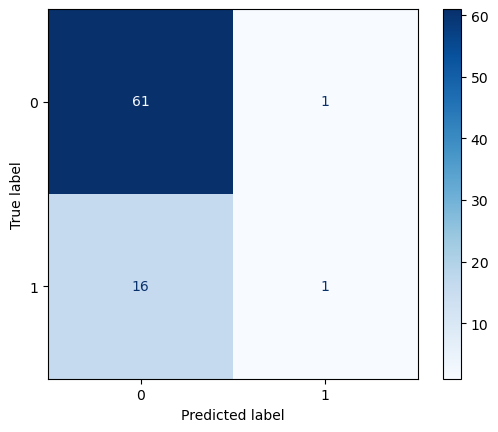

In [191]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = mlp.predict(Xs_test_reduced)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)